In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
train_df=pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_df_shuffled = train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
len(train_df),len(test_df)

(7613, 3263)

In [7]:
#Visualising data
import random
random_index = random.randint(0,len(train_df)-5)

for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _,text,target = row
    print(f"Target : {target}"," (Real Disaster)" if target==1 else "(Not a Disaster)")
    print(f"Text :\n{text}\n")
    print("----\n")

Target : 1  (Real Disaster)
Text :
13 security personnel killed in Iraq suicide bombing | http://t.co/IbAZRHlSUr http://t.co/B6wWq2nYQI

----

Target : 0 (Not a Disaster)
Text :
Panicking because maybe my bff left me at China Bar or maybe tindering on the toilet for 20mins

----

Target : 1  (Real Disaster)
Text :
@ameenshaikh3 by ur. logic if bridge didnt collapse then second train engine should cross bridge then  @sanjaynirupam @sureshprabhu

----

Target : 0 (Not a Disaster)
Text :
lmao fuckboy changed his @ for damage control
@Pseudojuuzo

----

Target : 1  (Real Disaster)
Text :
#Battlefield 1942 forgotten hope secret weapons

----



## Splitting data into training and validation sets

In [8]:
X_train,X_val,y_train,y_val = train_test_split(train_df_shuffled["text"].to_numpy(),
                                               train_df_shuffled["target"].to_numpy(),
                                               test_size=0.1,random_state=42)

In [9]:
len(X_train),len(X_val),len(y_train),len(y_val)

(6851, 762, 6851, 762)

In [10]:
# Checking top 5 samples
X_train[:5],y_train[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array([0, 0, 1, 0, 0], dtype=int64))

## Converting text data into number

In [11]:
# Text Vectorization (Tokenization)
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#Using default parameteras
text_vectorizer = TextVectorization(max_tokens=None, # Total no. of words in the vocab (if it is set to 100 it will take most common 100 words and replace rest with<OOV>)
                                    standardize="lower_and_strip_punctuation", #Lower case string
                                    split="whitespace", #Break the tokens on spaces
                                    ngrams=None, # Creategroups of n words
                                    output_mode="int", # To map tokens with numbers
                                    output_sequence_length=None, # Length of tokens
                                    pad_to_max_tokens=True)

In [12]:
#Find the average number of tokens (words) in each tweet
round(sum([len(item.split()) for item in X_train])/len(X_train))

15

In [13]:
#Setup text vectorization in variables
max_vocab_length = 10000
max_length = 15

#Using default parameteras
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,output_mode="int",output_sequence_length=max_length)

#Fit the vectorizer to training data
text_vectorizer.adapt(X_train)

In [14]:
#Create a sample sentence and tokenize it
text_vectorizer([X_train[23]])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1193, 1740, 2040, 2696, 1645, 2130, 1879,  248,   83,  322,  120,
         193,   18,  462,    1]], dtype=int64)>

In [15]:
#Checking total words 
total_word_vocab = text_vectorizer.get_vocabulary()

In [16]:
total_word_vocab[:5]

['', '[UNK]', 'the', 'a', 'in']

## Creating  embadding  with an embadding layer

In [17]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,output_dim=128,input_length=max_length)
embedding

In [18]:
#Create a sample sentence and embed it
embedded_sentence = embedding(text_vectorizer([X_train[23]]))

In [19]:
embedded_sentence

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-2.7777329e-03, -4.2948972e-02, -8.9228526e-03, ...,
          3.4008089e-02,  4.9238231e-02,  3.2595050e-02],
        [ 4.0701400e-02, -4.5391262e-02,  3.9375234e-02, ...,
          1.7802801e-02,  1.9731522e-03, -4.6471942e-02],
        [-5.1864237e-04,  2.3384783e-02,  3.5191070e-02, ...,
          4.9832966e-02, -1.3081301e-02,  4.1282240e-02],
        ...,
        [-2.2172904e-02, -4.1897409e-03,  1.2636185e-05, ...,
          1.6679876e-03,  1.0239705e-03, -2.0671451e-02],
        [-4.9943533e-02, -3.1334005e-02, -2.8706038e-02, ...,
         -1.2612566e-03, -2.4933442e-03, -3.3519648e-02],
        [-1.9809827e-03, -4.0068936e-02,  1.2618292e-02, ...,
          4.0014241e-02, -6.0355179e-03,  1.7127048e-02]]], dtype=float32)>

## Modelling a text dataset

We'll be building the following:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data


In [20]:
#Building Model 0 Naive Bayes (baseline)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create tokenization and modeling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()), #convert words to numbers usinf tfidf
    ("clf",MultinomialNB()) # Model the text
    
])

#Fit the pipeline with training data
model_0.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate the baseline model
baseline_score = model_0.score(X_val,y_val)
baseline_score

0.7926509186351706

In [22]:
# Making Prediction
baseline_preds=model_0.predict(X_val)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [23]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,"precision": model_precision,"recall": model_recall,"f1": model_f1}
    return model_results

In [24]:
# Get baseline results
baseline_results = calculate_results(y_true=y_val,y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [25]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


In [26]:
#Building Model 1  Feed-forward neural network (dense model)
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
x= text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,outputs,name="model_1_dense")

In [27]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile a model
model_1.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [29]:
# Fit the model
SAVE_DIR="model_logs"
model_1_history= model_1.fit(x=X_train,y=y_train,epochs=5,validation_data=(X_val,y_val),callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20210522-125940
Epoch 1/5
215/215 [==============================] - 21s 53ms/step - loss: 0.6536 - accuracy: 0.6472 - val_loss: 0.5355 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.4626 - accuracy: 0.8158 - val_loss: 0.4700 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 7s 33ms/step - loss: 0.3569 - accuracy: 0.8589 - val_loss: 0.4579 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 7s 33ms/step - loss: 0.2862 - accuracy: 0.8910 - val_loss: 0.4657 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 7s 34ms/step - loss: 0.2397 - accuracy: 0.9123 - val_loss: 0.4820 - val_accuracy: 0.7874


In [30]:
model_1.evaluate(X_val,y_val)

24/24 [==============================] - 0s 9ms/step - loss: 0.4820 - accuracy: 0.7874


[0.4819549322128296, 0.787401556968689]

In [31]:
model_1_preds_probs = model_1.predict(X_val)

In [32]:
model_1_preds_probs.shape

(762, 1)

In [33]:
model_1_preds= tf.squeeze(tf.round(model_1_preds_probs))

In [34]:
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [35]:
model_1_results = calculate_results(y_true=y_val,y_pred=model_1_preds)

In [36]:
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7932296029485675,
 'recall': 0.7874015748031497,
 'f1': 0.7841130596930417}

In [37]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Visualize learned embadding

In [38]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [39]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Get the weight matrix of embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

In [41]:
# Create embedding files
import io
out_v = io.open('vectors.tsv','w',encoding='utf-8')
out_m = io.open('metadata.tsv','w',encoding='utf-8')
for index,word in enumerate(words_in_vocab):
    if index==0:
        continue
    vec = embed_weights[index]
    out_v.write('\t'.join([str(x) for x in vec])+"\n")
    out_m.write(word +"\n")
out_v.close()
out_m.close()

Use this link to get your data visualized -- https://projector.tensorflow.org/

Need to upload the vector and metadata file created from above cell on this link.

## Recurrent Nueral Network (RNN)

Model 2 LSTM (Long short term Memory)

Input(text) --> Tokens --> Embedding --> Layers(RNN/Dense) --> Ouput (Label Probability)


In [42]:
# Create a LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(units=64,return_sequences=True)(x)
x = layers.LSTM(64)(x)
#x = layers.Dense(64,activation="relu")(x)
ouputs = layers.Dense(1,activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,ouputs,name="model_2_LSTM")

In [43]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [44]:
#Compile the model
model_2.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [45]:
# Fit the model
model_2_history = model_2.fit(X_train,y_train,epochs=5,validation_data=(X_val,y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210522-130037
Epoch 1/5
215/215 [==============================] - 29s 59ms/step - loss: 0.2796 - accuracy: 0.8998 - val_loss: 0.5640 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 9s 40ms/step - loss: 0.1523 - accuracy: 0.9419 - val_loss: 0.6166 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 9s 40ms/step - loss: 0.1307 - accuracy: 0.9492 - val_loss: 0.6768 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0977 - accuracy: 0.9636 - val_loss: 0.7630 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0806 - accuracy: 0.9693 - val_loss: 0.9425 - val_accuracy: 0.7690


In [46]:
# Make Predictions with LSTM model 
model_2_pred_probs= model_2.predict(X_val)
model_2_pred_probs[:10]

array([[7.5414844e-02],
       [8.1368840e-01],
       [9.9984789e-01],
       [2.7676988e-02],
       [5.5212493e-04],
       [9.9912757e-01],
       [9.4829124e-01],
       [9.9989641e-01],
       [9.9980813e-01],
       [5.9849602e-01]], dtype=float32)

In [47]:
# Convert model_2 preds to labels
model_2_pred_probs= tf.squeeze(tf.round(model_2_pred_probs))
model_2_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [48]:
model_2_results=calculate_results(y_val,model_2_pred_probs)
model_2_results

{'accuracy': 76.9028871391076,
 'precision': 0.7697342660172047,
 'recall': 0.7690288713910761,
 'f1': 0.7674269881907728}

## Model 3 : GRU 

In [49]:
# Build a RNN using tensorflow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
ouputs = layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,ouputs,name="model_3_GRU")

In [50]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Compile the model
model_3.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [52]:
#Fit the model
model_3_history = model_3.fit(X_train,y_train,epochs=5,validation_data=(X_val,y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210522-130144
Epoch 1/5
215/215 [==============================] - 16s 62ms/step - loss: 0.2678 - accuracy: 0.8793 - val_loss: 0.8338 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0692 - accuracy: 0.9745 - val_loss: 0.9042 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0666 - accuracy: 0.9738 - val_loss: 0.9612 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0619 - accuracy: 0.9769 - val_loss: 1.0674 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0459 - accuracy: 0.9802 - val_loss: 1.3069 - val_accuracy: 0.7756


In [53]:
# Make Predictions with GRU model 
model_3_pred_probs= model_3.predict(X_val)
model_3_pred_probs[:10]

array([[4.9914117e-04],
       [6.5996635e-01],
       [9.9992347e-01],
       [6.2968150e-02],
       [1.1507374e-04],
       [9.9988186e-01],
       [9.3765157e-01],
       [9.9996543e-01],
       [9.9993646e-01],
       [9.9595547e-01]], dtype=float32)

In [54]:
# Convert model_3 preds to labels
model_3_pred_probs= tf.squeeze(tf.round(model_3_pred_probs))
model_3_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [55]:
model_3_results=calculate_results(y_val,model_3_pred_probs)
model_3_results

{'accuracy': 77.55905511811024,
 'precision': 0.7794121823201254,
 'recall': 0.7755905511811023,
 'f1': 0.7726614113025507}

## Model 4 - Bidirectional RNN

In [56]:
# Build a bidirectional RNN model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
ouputs = layers.Dense(1,activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,ouputs,name="model_4_bidirectional")

In [57]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Compile the model
model_4.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [59]:
#Fit the model
model_4_history = model_4.fit(X_train,y_train,epochs=5,validation_data=(X_val,y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_4_bidirec")])

Saving TensorBoard log files to: model_logs/model_4_bidirec/20210522-130237
Epoch 1/5
215/215 [==============================] - 21s 77ms/step - loss: 0.1934 - accuracy: 0.9333 - val_loss: 0.8786 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0494 - accuracy: 0.9784 - val_loss: 1.1515 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 9s 44ms/step - loss: 0.0419 - accuracy: 0.9819 - val_loss: 1.4662 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 10s 46ms/step - loss: 0.0367 - accuracy: 0.9819 - val_loss: 1.5309 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 9s 44ms/step - loss: 0.0357 - accuracy: 0.9824 - val_loss: 1.4224 - val_accuracy: 0.7795


In [60]:
# Make Predictions with Bidirectional model 
model_4_pred_probs= model_4.predict(X_val)
model_4_pred_probs[:10]

array([[6.3573234e-03],
       [6.5471900e-01],
       [9.9996793e-01],
       [2.6473811e-01],
       [2.3227249e-05],
       [9.9973935e-01],
       [9.8971444e-01],
       [9.9998987e-01],
       [9.9996161e-01],
       [9.5486802e-01]], dtype=float32)

In [61]:
# Convert model_4 preds to labels
model_4_pred_probs= tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [62]:
model_4_results=calculate_results(y_val,model_4_pred_probs)
model_4_results

{'accuracy': 77.95275590551181,
 'precision': 0.7822644211580037,
 'recall': 0.7795275590551181,
 'f1': 0.7771404562571971}

## Model 5 - Conv1D

In [63]:
# Testing embedding layer, Conv1D and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["This is a sentence"]))
conv_1d = layers.Conv1D(filters=32,kernel_size=5,activation="relu",padding="valid")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape,conv_1d_output.shape,max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [64]:
# Create 1-d convolutional layer to model sequence
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,kernel_size=5,strides=1,activation="relu",padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
ouputs = layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs,ouputs,name="model_5_Conv1D")

In [65]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [66]:
# Compile the modeldd
model_5.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [67]:
#Fit the model
model_5_history = model_5.fit(X_train,y_train,epochs=5,validation_data=(X_val,y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20210522-130343
Epoch 1/5
215/215 [==============================] - 12s 53ms/step - loss: 0.1850 - accuracy: 0.9412 - val_loss: 0.9947 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0748 - accuracy: 0.9745 - val_loss: 1.0991 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0551 - accuracy: 0.9771 - val_loss: 1.1731 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0502 - accuracy: 0.9798 - val_loss: 1.2054 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0456 - accuracy: 0.9806 - val_loss: 1.2632 - val_accuracy: 0.7572


In [68]:
# Make Predictions with Conv1D model 
model_5_pred_probs= model_5.predict(X_val)
model_5_pred_probs[:10]

array([[1.6577759e-01],
       [9.7743750e-01],
       [9.9993253e-01],
       [6.6378511e-02],
       [2.3925534e-07],
       [9.9373794e-01],
       [9.9479890e-01],
       [9.9998844e-01],
       [9.9999976e-01],
       [9.0116113e-01]], dtype=float32)

In [69]:
# Convert model_5 preds to labels
model_5_pred_probs= tf.squeeze(tf.round(model_5_pred_probs))
model_5_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
model_5_results=calculate_results(y_val,model_5_pred_probs)
model_5_results

{'accuracy': 75.7217847769029,
 'precision': 0.7572094843193692,
 'recall': 0.7572178477690289,
 'f1': 0.7559398344614434}

In [71]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 6 : Tensorflow hub Pre Trained sentence encoder

In [72]:
import tensorflow_hub as hub
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
#embed_samples = embed(["This is a sample tweet "])

In [73]:
#embed_samples[0][:50]

In [74]:
#embed_samples[0].shape

In [75]:
#Create a Keras Layer using the pre trained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],dtype=tf.string,trainable=False,name="USE")

In [76]:
# Create Model using sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
],name="model_6_USE")

In [77]:
# Compile the model
model_6.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [78]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [79]:
#Fit the model
model_6_history = model_6.fit(X_train,y_train,epochs=5,validation_data=(X_val,y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="tf_hub_sentence_enc")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_enc/20210522-130457
Epoch 1/5
215/215 [==============================] - 29s 116ms/step - loss: 0.5769 - accuracy: 0.7505 - val_loss: 0.4489 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 9s 41ms/step - loss: 0.4136 - accuracy: 0.8174 - val_loss: 0.4357 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 9s 41ms/step - loss: 0.4001 - accuracy: 0.8173 - val_loss: 0.4346 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 10s 45ms/step - loss: 0.3762 - accuracy: 0.8366 - val_loss: 0.4279 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 9s 41ms/step - loss: 0.3717 - accuracy: 0.8373 - val_loss: 0.4254 - val_accuracy: 0.8176


In [80]:
# Make Predictions
model_6_pred_probs= model_6.predict(X_val)
model_6_pred_probs[:10]

array([[0.1687635 ],
       [0.7759173 ],
       [0.9874978 ],
       [0.22713077],
       [0.71038115],
       [0.7440115 ],
       [0.98087585],
       [0.97782284],
       [0.9416915 ],
       [0.09311038]], dtype=float32)

In [81]:
# Convert model_6 preds to labels
model_6_pred_probs= tf.squeeze(tf.round(model_6_pred_probs))
model_6_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [82]:
model_6_results=calculate_results(y_val,model_6_pred_probs)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8217449491045319,
 'recall': 0.8175853018372703,
 'f1': 0.8155543679852177}

In [83]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7 : Tensorflow pretrained USE but with 10% of the training data

In [127]:
# Create subset of 10% of the training data
train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)
train_10_percent.head(),len(train_10_percent)

(                                                   text  target
 4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
 584   FedEx no longer to transport bioterror germs i...       0
 7411  Gunmen kill four in El Salvador bus attack: Su...       1
 5950  @camilacabello97 Internally and externally scr...       1
 5541  Radiation emergency #preparedness starts with ...       1,
 761)

In [128]:
len_10_percent_split = int(0.1*len(X_train))
train_sentences_10_percent= X_train[:len_10_percent_split]
train_labels_10_percent = y_train[:len_10_percent_split]

In [130]:
train_sentences_10_percent[:10],train_labels_10_percent[:10],len(train_sentences_10_percent),len(train_labels_10_percent)

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [131]:
 train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [132]:
# Create Model using sequential API for 10 percent data
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
],name="model_7_USE_10_percent")

In [133]:
# Compile the model
model_7.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [134]:
model_7.summary()

Model: "model_7_USE_10_percent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_11 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [135]:
#Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,train_labels_10_percent,epochs=5,validation_data=(X_val,y_val),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="tf_hub_sentence_enc_10_percent")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_enc_10_percent/20210522-141639
Epoch 1/5
22/22 [==============================] - 14s 617ms/step - loss: 0.6779 - accuracy: 0.6910 - val_loss: 0.6447 - val_accuracy: 0.7520
Epoch 2/5
22/22 [==============================] - 2s 76ms/step - loss: 0.6190 - accuracy: 0.7705 - val_loss: 0.5881 - val_accuracy: 0.7625
Epoch 3/5
22/22 [==============================] - 2s 76ms/step - loss: 0.5312 - accuracy: 0.8273 - val_loss: 0.5316 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 2s 77ms/step - loss: 0.4608 - accuracy: 0.8246 - val_loss: 0.5016 - val_accuracy: 0.7664
Epoch 5/5
22/22 [==============================] - 2s 79ms/step - loss: 0.4215 - accuracy: 0.8323 - val_loss: 0.4900 - val_accuracy: 0.7730


In [136]:
# Make Predictions
model_7_pred_probs= model_7.predict(X_val)
model_7_pred_probs[:10]

array([[0.17920712],
       [0.6107348 ],
       [0.9126516 ],
       [0.37477422],
       [0.48259476],
       [0.67939913],
       [0.87831867],
       [0.8119054 ],
       [0.86299425],
       [0.1766876 ]], dtype=float32)

In [137]:
# Convert model_7 preds to labels
model_7_pred_probs= tf.squeeze(tf.round(model_7_pred_probs))
model_7_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [138]:
model_7_results=calculate_results(y_val,model_7_pred_probs)
model_7_results

{'accuracy': 77.29658792650919,
 'precision': 0.7740517401498704,
 'recall': 0.7729658792650919,
 'f1': 0.7712160418848196}

## Comparing the performance of each of our models

In [143]:
#Combine model results into a data frame
all_model_results= pd.DataFrame({"0_baseline":baseline_results,
                                 "1_simple_dense":model_1_results,
                                 "2_lstm":model_2_results,
                                 "3_gru":model_3_results,
                                 "4_bidirectional":model_4_results,
                                 "5_conv1d":model_5_results,
                                 "6_tf_hub_use_encoder":model_6_results,
                                 "7_tf_hub_use_encoder_10_percent":model_7_results
                                })
all_model_results=all_model_results.transpose()

In [144]:
all_model_results["accuracy"]=all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.787402,0.793230,0.787402,0.784113
2_lstm,0.769029,0.769734,0.769029,0.767427
3_gru,0.775591,0.779412,0.775591,0.772661
4_bidirectional,0.779528,0.782264,0.779528,0.777140
5_conv1d,0.757218,0.757209,0.757218,0.755940
6_tf_hub_use_encoder,0.817585,0.821745,0.817585,0.815554
7_tf_hub_use_encoder_10_percent,0.772966,0.774052,0.772966,0.771216


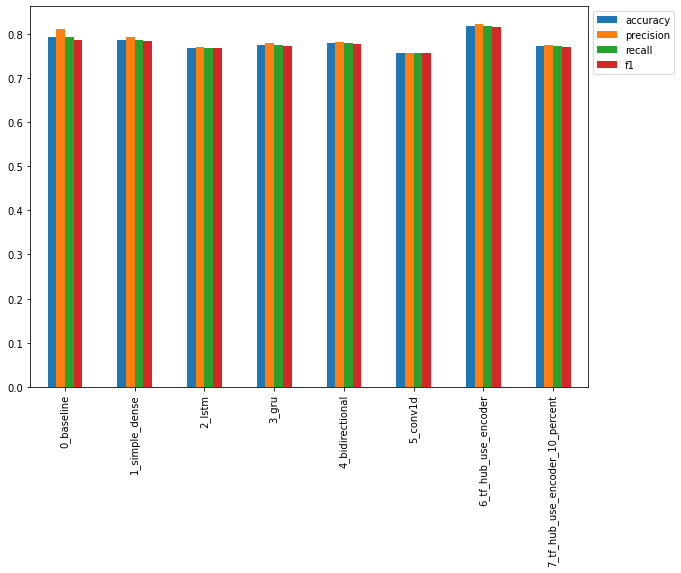

In [148]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<AxesSubplot:>

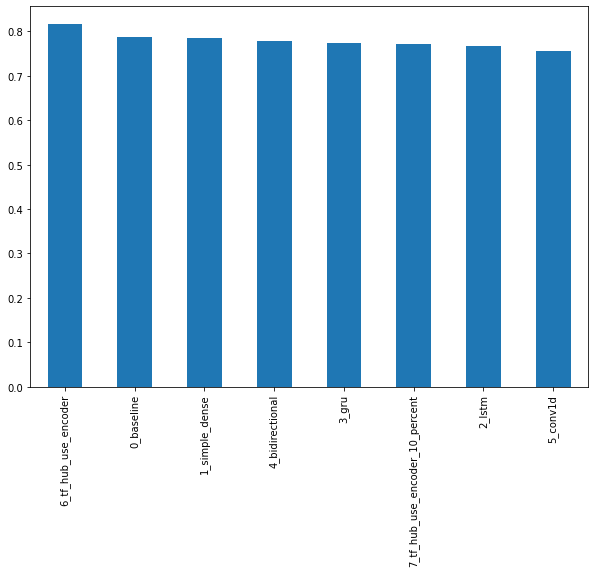

In [149]:
# Sort the model results by f1 score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

## Saving and loading a trained model

In [151]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

## Making predictions on the test dataset

In [153]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")

Pred: 1, Prob: 0.9303227663040161
Text:
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/WbCtkGGTY9

----

Pred: 0, Prob: 0.07318724691867828
Text:
New Ladies Shoulder Tote Handbag Faux Leather Hobo Purse Cross Body Bag Womens - Full readÛ_ http://t.co/Rpn6pXLPiB http://t.co/l6aYlVVDZ0

----

Pred: 0, Prob: 0.0738363265991211
Text:
stay with me - sam.smith

----

Pred: 0, Prob: 0.17569909989833832
Text:
/criess blood/ Golden Wook is life. http://t.co/Fhb99ciCeT

----

Pred: 0, Prob: 0.2841106653213501
Text:
That @PPact hasn't already collapsed is a testament to @TheDemocrats lockstep devotion to politics over reality.

----

Pred: 0, Prob: 0.04624858498573303
Text:
@RobynJilllian @WlSDOMTEETHS I feel like I'm going to do it on accident. Teesha is gonna come out??

----

Pred: 0, Prob: 0.1925230324268341
Text:
#7294 Nikon D50 6.1 MP Digital SLR Camera Body 2 batteries carry bag and charger http://t.co/SL7PH

## Predicting on Tweets from the wild

In [155]:
# Turn Tweet into string
random_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [156]:
def predict_on_sentence(model, sentence):
    pred_prob = model.predict([sentence])
    pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
    print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
    print(f"Text:\n{sentence}")

In [157]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=random_tweet)

Pred: 0.0 (not real disaster) Prob: 0.04752316325902939
Text:
Life like an ensemble: take the best choices from others and make your own


In [158]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [159]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

Pred: 1.0 (real disaster) Prob: 0.9646546840667725
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [160]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

Pred: 1.0 (real disaster) Prob: 0.9779004454612732
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


In [84]:
test_df.shape

(3263, 4)

In [85]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [86]:
y_test_labels= test_df["text"]

In [87]:
y_test_labels

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [88]:
y_labels_preds=model_6.predict(y_test_labels)
y_labels_preds= tf.squeeze(tf.round(y_labels_preds))

In [89]:
y_labels_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [90]:
result_df = pd.DataFrame({'id': test_df["id"], 'target': tf.cast(y_labels_preds, tf.int32)}, columns=['id', 'target'])

In [91]:
result_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [92]:
result_df.to_csv("first_submission.csv",index=0)

In [93]:
y_labels_preds.dtype

tf.float32

## The speed/score tradeoff

In [164]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    end_time = time.perf_counter() # get finish time
    total_time = end_time-start_time # calculate how long predictions took to make
    time_per_pred = total_time/len(X_val) # find prediction time per sample
    return total_time, time_per_pred

In [165]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, X_val)
model_6_total_pred_time, model_6_time_per_pred

(1.1104267999999138, 0.0014572530183725903)

In [167]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, X_val)
baseline_total_pred_time, baseline_time_per_pred

(0.08701750000000175, 0.00011419619422572408)

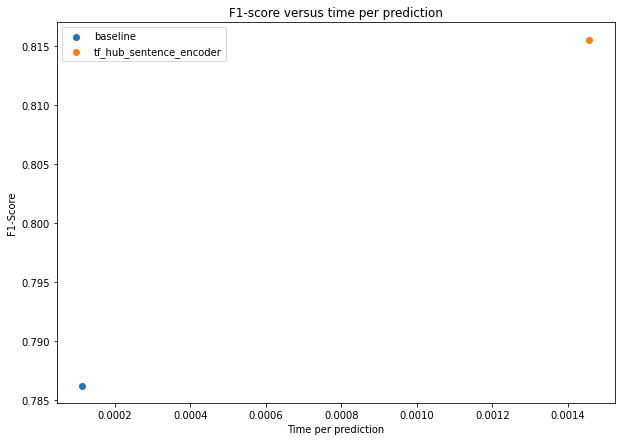

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");